# Taxi Trip Data - 45341338

**Youtube Links**

Part 1: https://youtu.be/WpDvl7bbWMw

Part 2: https://youtu.be/-JiGdne-o8o 

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount= True)

%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [2]:
%cd '/gdrive/MyDrive/Masters2022-2024/COMP8210-BigDataTechnologies/Assignment3/A3'

/gdrive/MyDrive/Masters2022-2024/COMP8210-BigDataTechnologies/Assignment3/A3


In [3]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Task 1: Data Import

### A) Load Files

 We will begin by importing the three parquet files for the months of January, March and June for the Taxi trips recorded across New York City, USA. [Parquet](https://python.plainenglish.io/how-to-read-parquet-files-in-python-without-a-distributed-cluster-4d4e8ba600e5) files are column oriented data file formats that provide data compression and encoding schemes that enhance performance. Since it is a column store file, data files are organised by columns not rows which saves on storage and speeds up analytical queries. Parquet also supports complex data types and nested data structures. However, Parquet files don’t support spatial and geometry data types which was an issue later on in this analysis.

    
    
  

In [4]:
jan_data = pd.read_parquet('yellow_tripdata_2023-01.parquet', engine='pyarrow')
march_data = pd.read_parquet('yellow_tripdata_2023-03.parquet', engine = 'pyarrow')
june_data = pd.read_parquet('yellow_tripdata_2023-06.parquet', engine = 'pyarrow')
# pyarrow is the engine used by python to read in the parquet file

In [5]:
jan_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
june_data.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-01 00:08:48,2023-06-01 00:29:41,1.0,3.4,1.0,N,140,238,1,21.9,3.50,0.5,6.7,0.0,1.0,33.60,2.5,0.00
1,1,2023-06-01 00:15:04,2023-06-01 00:25:18,0.0,3.4,1.0,N,50,151,1,15.6,3.50,0.5,3.0,0.0,1.0,23.60,2.5,0.00
2,1,2023-06-01 00:48:24,2023-06-01 01:07:07,1.0,10.2,1.0,N,138,97,1,40.8,7.75,0.5,10.0,0.0,1.0,60.05,0.0,1.75


#### Import supplementary data.

Further along in our analysis we will make use of supplementary data such as the Taxi Zone look up table and the taxi-zone shapefile.

In [7]:
# taxi zone lookup table
zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
zone_lookup.head(3)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone


In [8]:
# shapefile
zone_shp = gpd.read_file("taxi_zones/taxi_zones.shp")
zone_shp.head(3)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."


The zone look up table and shapefile share common information to which we can leverage in our further analysis and use them as reference and tables to join on to the main dataset. Manual inspection reveals that there are 2 zones '264' and '264' which are unknown zones and are not covered by the shapefile. These zones will not be of use to us in future even if they are included in the main taxi data set.

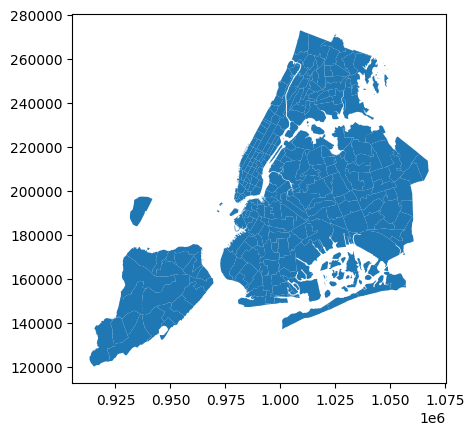

In [9]:
# simple plot of the shape file
zone_shp.plot()
plt.show()

### B) 3 Monthly trends
Within this section, I will compare the three months of data through a series of trends as a form of basic data exploration. The three trends I have decided to look at are:




1. What is the airport activity across the three airports, across the three months?
2. How many single passenger trips contribute to the volume of traffic on Mondays, wednesdays and fridays across the three months?
3. How does the median tip paid fluctuate on Wednesdays across the three months for single passenger trips.


First lets prepare the data by combining the three datasets into one and tidying up the headers.
 First lets combine the data into one large dataframe to visualise it across the 3 months.

In [9]:
# assign month indicators to each dataset
jan_data['Month'] = 'Jan'
march_data['Month'] = 'March'
june_data['Month']= 'June'

In [10]:
# change the january column names to match the other two
jan_data.columns =june_data.columns

# check if the other two have the same column names
#march_data.columns== june_data.columns

# check if conversion worked
#march_data.columns== jan_data.columns

In [11]:
# union the three months of data together
unioned_df = pd.concat([jan_data, march_data,june_data], ignore_index= True)

In [12]:
# checks on the unioned_df dimensions and compare to the row and column counts of the other dfs
print("Unioned data frame dimensions:", unioned_df.shape)
print("January data dimensions:", jan_data.shape)
print("March data dimensions:", march_data.shape)
print("June data dimensions:", june_data.shape)

Unioned data frame dimensions: (9777766, 20)
January data dimensions: (3066766, 20)
March data dimensions: (3403766, 20)
June data dimensions: (3307234, 20)


In [13]:
unioned_df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0,Jan
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0,Jan
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.0,0.0,1.0,34.9,2.5,0.0,Jan


**Trend 1: Airport Activity Across Each Month**


I want to explore how the trips originating from each airport (passengers getting picked up at airports) vary from month to month and from airport to airport.
Referencing the taxi zone look up table, pick up locations for airports are:
- 1: Newark Airport
- 132: JFK Airport
- 138: Laguardia Airport

First we need to do some preliminary cleaning because there are NaN values and 0.0 passenger counts, since the aim is to visualise the number of valid taxi trips that pick up passengers from each airport. We subset the dataset for these three airports as well.



In [14]:
# filter for people being picked up from the airport by pickup location id
airport_ids = [1, 132,138]
airport = unioned_df[unioned_df['PULocationID'].isin(airport_ids)]
# check for nulls
#airport.isna().sum()

In [15]:
# drop those rows
airport_drop= airport.dropna(how = "any", axis=0)

# filter  for passenger counts > 0
airport_pass = airport_drop[airport_drop['passenger_count']>0.0]

# group trip counts by month, airport
port_names =pd.DataFrame({ 'PULocationID':[1, 132, 138],
              'Airport': ['Newark',  'JFK','Laguardia']})

airport_counts =airport_pass.groupby(['PULocationID', 'Month'])['PULocationID'].count().reset_index(name ='Count')
airports = airport_counts.merge(port_names, how= 'inner', on = 'PULocationID')
airports

,PULocationID,Month,Count,Airport
0,1,Jan,398,Newark
1,1,June,443,Newark
2,1,March,418,Newark
3,132,Jan,157804,JFK
4,132,June,177816,JFK
5,132,March,167549,JFK
6,138,Jan,87894,Laguardia
7,138,June,117886,Laguardia
8,138,March,113759,Laguardia


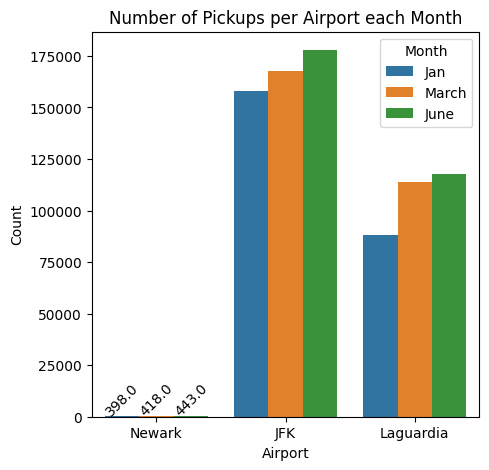

In [16]:
months = ["Jan", "March", "June"]
# Create the figure and axes objects.
fig, ax = plt.subplots(figsize=(5,5))

# Create a bar plot of the number of pickups per airport each month.
sns.barplot(
    x="Airport",
    y="Count",
    hue="Month",
    data=airports,
    hue_order=months,
    ax=ax,
)

# Annotate each bar with its count

for i in [0,3,6]:
  p = ax.patches[i]
  count = p.get_height()
  x = p.get_x() + p.get_width() / 2
  y = count
  ax.annotate(f"{count}", (x, y), ha="center", rotation= 45)

plt.title("Number of Pickups per Airport each Month")
plt.show()

#### Comments

JFK is the most popular airport out of the three. JFK serves both as a domestic and international airport and so we could expect both domestic and international travellers to comprise majority of the volume of taxi trips originating from here.

Laguardia follows JFK across all months. Laguardia is a domestic airport. Newark is the least popular airport to be picked up from across all three months.

According to [this article](https://www.blade.com/jfk-or-newark), the choice between each of these airports is dependent on a number of factors such as accessibility to pubslic transport, accommodation and other amenities. Even though Newark offers better transport options, JFK takes the lead each month.
It is also interesting to see that taxi pickups increase from January to June for all airports. It could be that more Americans are either returning from a summer holiday during June or more tourists visit America during the summer period.

**Trend 2: 1 Passenger trips on busiest weekdays**

The second trend I wanted to explore was how many single passenger trips contribute to the volume of traffic on Mondays, Wednesdays and Fridays across the 3 months.
To do this, I extracted the weekday day from the pickup date time object  and filtered for those trips that only contained 1 passenger. Grouping by the days of interest we end ip with a frequency table for the three months.


In [17]:
unioned_df['day']= unioned_df['tpep_pickup_datetime'].dt.strftime('%A')

In [19]:
# filter for 1 passenger trips
one_pass = unioned_df[unioned_df['passenger_count']==1.0]

# filter for Mon, Wed, Fri
day_ls = ["Monday", "Wednesday", "Friday"]
pass_day = one_pass[one_pass['day'].isin(day_ls)]

In [20]:
pass_counts =pass_day.groupby(['Month', 'day'])['day'].count().reset_index(name ="Count")
pass_counts

,Month,day,Count
0,Jan,Friday,319333
1,Jan,Monday,302340
2,Jan,Wednesday,322172
3,June,Friday,399653
4,June,Monday,294625
5,June,Wednesday,357455
6,March,Friday,421894
7,March,Monday,290647
8,March,Wednesday,442387


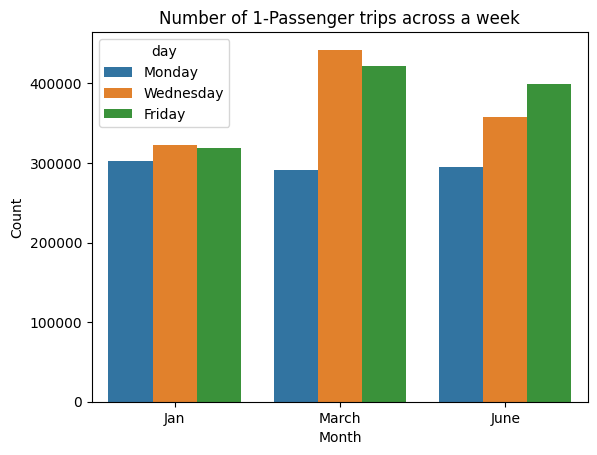

In [21]:

months = ["Jan", "March", "June"]

sns.barplot(data=pass_counts,
             x="Month",
             y="Count",
             hue="day",
             hue_order = day_ls,
             order = months)

plt.title("Number of 1-Passenger trips across a week")
plt.show()

#### Comments

It's clear that single passenger trips account for a very large proportion of trips and then the volume of traffic across the period of interest. What is interesting is that Wednesdays account for the highest single passenger trips in March but Fridays accounted for the highest numbers in June.

**Trend 3: Average Tips paid on Wednesdays by 1-Passenger trips**

Utilising the above subset of data I now want to see that specifically for wednesdays, how does the trip paid fluctuate across the span of the day and then facet that by the months of interest. So first we further subset the data for wednesdays only and extract the 24-Hour hour from the pick up time.

In [22]:
pass_wed =pass_day[pass_day['day']=="Wednesday"]

In [ ]:
# extract hour from pick up time
pass_wed['PU_Hr']= pass_wed['tpep_pickup_datetime'].apply(lambda x: x.hour)

In [24]:
pass_wed.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,day,PU_Hr
209091,2,2008-12-31 23:04:41,2009-01-01 19:55:36,1.0,0.00,1.0,N,7,7,2,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,Jan,Wednesday,23
219611,2,2023-01-04 00:01:15,2023-01-04 00:08:06,1.0,2.87,1.0,N,233,263,1,...,0.5,3.56,0.0,1.0,21.36,2.5,0.0,Jan,Wednesday,0


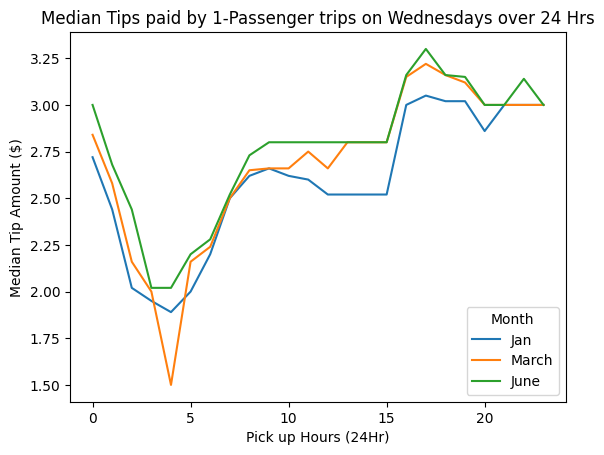

In [27]:
medians= pass_wed.groupby(['PU_Hr', 'Month'])['tip_amount'].median().reset_index(name ="Median")
sns.lineplot(data = medians,
             x= 'PU_Hr',
             y = 'Median',
             hue= 'Month',
             hue_order = months
)
plt.xlabel("Pick up Hours (24Hr)")
plt.ylabel("Median Tip Amount ($)")
plt.title("Median Tips paid by 1-Passenger trips on Wednesdays over 24 Hrs")
plt.show()

####Comments

From the above chart, it's quite interesting to see that all three months follow a similar pattern with median tips being paid throughout the day on Wednesdays in particular. They all seem to decrease from $2.75- $3.00 to $1.50-$2.00 between midnight and 5 AM. The tips paid then steadily increase from then until midnight again to $3.00 and more.

# Task 2: Data Exploration and Preprocessing


In [ ]:
# checking for missing values

jan_data.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
Airport_fee              71743
dtype: int64

### A)  Checking for Missing Values and handling them

In this section, we seek to understand our data better by exploring it and pre-processing it.
We first checked for missing values. There are a total of 71,743 NaN values for `Passenger count`,  `RateCodeID`, `store_and_fwd_flag`, `congestion_surcharge` and `airport fee`. Cross referencing the data dictionary, it can be understood that these columns should be populated when the meter is engaged.

There are also instances where trip distances are ‘0 Miles’ despite the taxi being recorded as travelling between two different zones and an amount is being charged indicated by the total amount and fare amount columns being populated. It is possible that these trips were simply automatically recorded despite there being no passengers present. Whether or not to remove these rows is dependent on our ability to conduct future analysis and impute meaningful data values as a replacement. For future analysis such as comparing the correlation of trip fares with passenger counts would deem inaccurate as some of the data would contain trip fares for taxi trips with no passengers at all. Additionally, we cannot impute the mean or median number of passengers, the rate code, payment types, airport fees or surcharges without further evidence/ information concerning the route or simply the nature of the taxi trip. For example, passengers can range from 1-5 on a given trip, different trips can have different combinations of locations, payment types, journey types etc. Since imputation is not feasible, the best course of action is to completely remove these rows from the dataset to increase the reliability of our data for future analysis.


In [ ]:
# check that missing data is related to missing passengers
jan_data[jan_data['passenger_count'].isna()].isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
Airport_fee              71743
Month                        0
dtype: int64

In [28]:
missing_data = jan_data[jan_data['passenger_count'].isna()]
missing_data.head()
#missing_data['payment_type'].describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN,Jan
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN,Jan
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN,Jan
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN,Jan
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN,Jan


In [29]:
# drop the missing values
jan_drop = jan_data.dropna(how = "any", axis=0)

In [ ]:
# check the drop happened correctly
#jan_drop.shape #(2995023, 20)
#jan_data.shape #(3066766, 20)

### B)  Which 2 columns have erroneous Value

Throughout this section there are more than two columns that have erroneous values. For categorical variables such as Rate Code ID,  Payment Types we can take a look at how their categories are distributed. For the remaining numeric columns, we can simply investigate erroneous values through a summary table given within the context of their values.


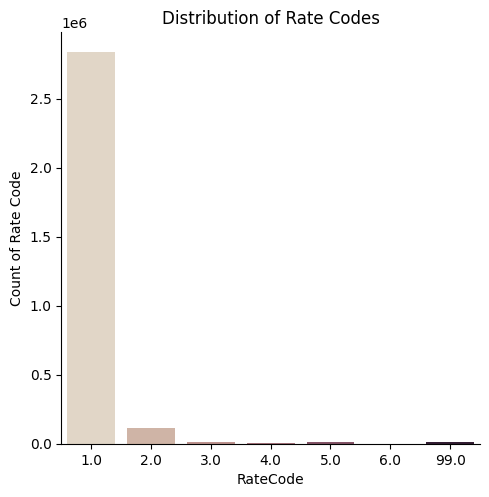

In [30]:
# histogram of RatecodeID
jan_drop = jan_drop.copy()
jan_drop['RatecodeID'] = jan_drop['RatecodeID'].astype(str)

sns.catplot(x="RatecodeID", kind="count", palette="ch:.25", data=jan_drop,order=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '99.0'])
plt.xlabel("RateCode")
plt.ylabel("Count of Rate Code")
plt.title("Distribution of Rate Codes")
plt.show()

In [31]:
jan_drop["RatecodeID"].value_counts().to_frame().sort_values(by=['RatecodeID'], ascending=False)

,RatecodeID
1.0,2839305
2.0,114239
5.0,15043
99.0,13106
3.0,8958
4.0,4366
6.0,6


#### Comments

**RatecodeID**
From the data dictionary, we know that RateCodeID has values encoded 1-6 and describes the rate applied at the end of the trip, determining how the fare is charged. From the histogram it is evident that there is an additional category ‘99.0’ which is not covered by the data dictionary. There are 13,106 erroneous values assigned to the code 99.0. Upon reflection, I hypothesised that these rows might have resulted from a glitch by the taxi not being connected to the server when a trip was logged. However, I found that only 19 of these trips with a 99.0 rate code were logged when the taxi was not connected to the server, leading me to believe that this was another system error. For the time being I have chosen to leave these trips alone and consider them as their own category and have not removed them from the data set.


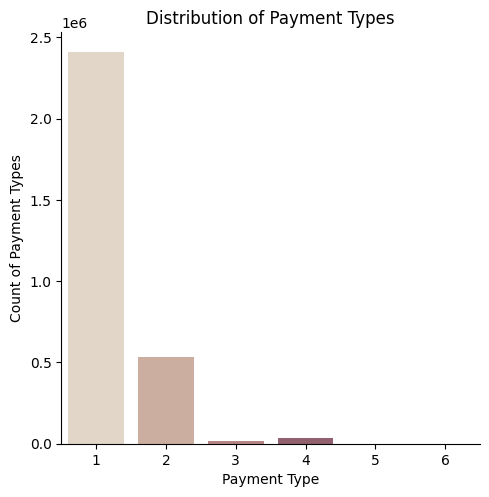

In [ ]:
# distribution of payment type
jan_drop = jan_drop.copy()
jan_drop['payment_type'] = jan_drop['payment_type'].astype(str)

sns.catplot(x="payment_type", kind="count", palette="ch:.25", data=jan_drop,order=['1', '2', '3', '4', '5', '6'])
plt.xlabel("Payment Type")
plt.ylabel("Count of Payment Types")
plt.title("Distribution of Payment Types")
plt.show()

#### Comments

**Payment Type**

Repeating the same process for Payment types, there were no unusual payment categories observed and this information is consistent with the data dictionary.


We will now move on to investgating the numeric columns and determining if there are any erroneous values.

### Numeric Columns:

- Trip Distances
- Fare Amount
- Total Amount
- Extra
- MTA Tax
- Improvement Tax
- Tip Amount
- Tolls Amount
- Congestion Surcharge
- Airport Fee

In [ ]:
amount_cols = [ 'trip_distance','fare_amount', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'total_amount']
summary = jan_drop[amount_cols].describe()

formatted_summary = summary.applymap(lambda x: "{0:.2f}".format(x))
formatted_summary

,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,total_amount
count,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00
mean,3.44,18.31,1.57,0.49,3.36,0.52,0.98,2.27,0.11,26.97
std,42.09,17.89,1.80,0.10,3.84,2.02,0.19,0.77,0.36,22.27
min,0.00,-900.00,-7.50,-0.50,-96.22,-65.00,-1.00,-2.50,-1.25,-751.00
25%,1.06,8.60,0.00,0.50,1.00,0.00,1.00,2.50,0.00,15.40
50%,1.78,12.80,1.00,0.50,2.72,0.00,1.00,2.50,0.00,20.02
75%,3.30,19.80,2.50,0.50,4.14,0.00,1.00,2.50,0.00,28.56
max,62359.52,1160.10,12.50,53.16,380.80,196.99,1.00,2.50,1.25,1169.40


#### Comments

For all dollar- amount columns, we expect to see only positive values within the context of taxi data as the ‘$’ amount must always be positive. Despite this assumption and constraint, the summary table demonstrates that all  amount columns contain thousands of negative values. This in turn will impact the total amount calculated. Removing all these negative values from the dataset by dropping the rows would result in severe data and information loss, impacting our analysis later on. The best course of action would be to take the absolute value of each of these amounts and recalculate the total fare amount manually.


In [ ]:
# Calculate value counts for each column in the subset where values are negative
value_counts = {col: jan_drop[jan_drop[col]<0.0][col].value_counts() for col in amount_cols}
# Print the value counts for each column
for col, counts in value_counts.items():
    print(f"Value counts for column {col}:")
    print(counts)
    print()






Value counts for column trip_distance:
Series([], Name: trip_distance, dtype: int64)

Value counts for column fare_amount:
-3.00     3163
-70.00    1704
-6.50     1024
-5.80     1017
-7.20      976
          ... 
-29.20       1
-10.30       1
-69.00       1
-29.33       1
-99.30       1
Name: fare_amount, Length: 409, dtype: int64

Value counts for column extra:
-1.00    7383
-2.50    3757
-5.00     859
-6.00     256
-7.50     141
-1.25       6
-0.50       3
-4.50       1
-3.50       1
Name: extra, dtype: int64

Value counts for column mta_tax:
-0.5    24498
Name: mta_tax, dtype: int64

Value counts for column tip_amount:
-0.90     80
-0.01     51
-0.13     34
-20.00     4
-0.08      4
-0.05      4
-2.00      3
-1.00      3
-1.04      2
-0.54      2
-2.58      2
-1.40      1
-64.66     1
-4.90      1
-4.50      1
-5.00      1
-1.35      1
-35.03     1
-6.08      1
-1.60      1
-11.11     1
-4.00      1
-90.09     1
-1.67      1
-2.24      1
-2.09      1
-0.71      1
-6.83      1
-7.00 

In [32]:
# define the columns where abs() is taken of
recalc_cols = [ 'fare_amount', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
jan_abs = jan_drop
jan_abs[recalc_cols] = jan_abs[recalc_cols].applymap(abs)

In [33]:
jan_abs.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0,Jan
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0,Jan
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.0,0.0,1.0,34.9,2.5,0.0,Jan


Now that the absolute values have been taken for each of these numeric columns, lets check the descriptive statistics and recalculate the total fair charged.

In [ ]:
# check descriptive stats now that abs() has been taken
summary2 = jan_abs[recalc_cols].describe()
formatted_summary2 = summary2.applymap(lambda x: "{0:.2f}".format(x))
formatted_summary2

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
count,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00,2995023.00
mean,18.63,1.58,0.50,3.36,0.53,1.00,2.31,0.11
std,17.56,1.78,0.05,3.84,2.02,0.03,0.67,0.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8.60,0.00,0.50,1.00,0.00,1.00,2.50,0.00
50%,12.80,1.00,0.50,2.72,0.00,1.00,2.50,0.00
75%,20.50,2.50,0.50,4.14,0.00,1.00,2.50,0.00
max,1160.10,12.50,53.16,380.80,196.99,1.00,2.50,1.25


In [ ]:
# check that all numeric columns (related to money/ amounts) sum to equal the total amount

recalc_cols = [ 'fare_amount', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
# sum across the rows
jan_abs['Total_Fare_recalc']= jan_abs[recalc_cols].sum(axis = 1)
jan_abs.head()

<ipython-input-15-99cdb6d82719>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_abs['Total_Fare_recalc']= jan_abs[recalc_cols].sum(axis = 1)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,Jan,14.30
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,Jan,16.90
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,Jan,34.90
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,Jan,22.10
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,Jan,19.68


In [ ]:
# check the amount of rows that changed

rows = jan_abs['total_amount'] != jan_abs['Total_Fare_recalc']
counts = rows.value_counts().reset_index()
counts.columns = ['Equal', 'Count']
counts

,Equal,Count
0,False,1949494
1,True,1045529


After recalculating the total fare charged manually, 1,949,494 cases or rows were handled where the recalculated amount was not the same as the total amount. This step was absolutely critical to handle as it impacted well over 60% of our data.


### Pickup and Drop off times
Finally, we will look at whether there are any erroneous values with our pick up and drop off times. It is essential to check whether pick up times occur before the drop off times and vice versa.

In [ ]:
jan_abs.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,Jan,14.30
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,Jan,16.90
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,Jan,34.90
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,Jan,22.10
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,Jan,19.68


In [ ]:
pickup_times = jan_abs['tpep_pickup_datetime'] >= jan_abs['tpep_dropoff_datetime']
pu_counts = pickup_times.value_counts().reset_index()
pu_counts.columns = ['PU Times After DO', 'Count']

pu_counts

,PU Times After DO,Count
0,False,2993922
1,True,1101


In [ ]:
# see which instances have pick up times occurring after drop off times

jan_abs[pickup_times== True]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc
3291,1,2023-01-01 00:11:55,2023-01-01 00:11:55,1.0,0.0,5.0,Y,137,264,2,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,Jan,0.00
4971,1,2023-01-01 01:54:01,2023-01-01 01:54:01,1.0,0.0,1.0,N,237,264,2,...,3.50,0.5,0.0,0.00,1.0,8.0,2.5,0.00,Jan,10.50
11648,1,2023-01-01 02:45:08,2023-01-01 02:45:08,1.0,0.0,1.0,N,234,264,2,...,3.50,0.5,0.0,0.00,1.0,8.0,2.5,0.00,Jan,10.50
15664,1,2023-01-01 03:55:38,2023-01-01 03:55:38,1.0,0.0,1.0,N,48,264,2,...,3.50,0.5,0.0,0.00,1.0,8.0,2.5,0.00,Jan,10.50
22644,1,2023-01-01 07:24:56,2023-01-01 07:24:56,1.0,0.0,1.0,Y,116,264,2,...,2.50,0.5,0.0,0.00,1.0,14.7,0.0,0.00,Jan,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972577,1,2023-01-31 19:27:50,2023-01-31 19:27:50,2.0,0.0,1.0,N,142,264,2,...,5.00,0.5,0.0,0.00,1.0,33.3,2.5,0.00,Jan,35.80
2972578,1,2023-01-31 19:50:32,2023-01-31 19:50:32,2.0,5.8,1.0,N,13,13,1,...,5.00,0.5,2.0,0.00,1.0,35.3,2.5,0.00,Jan,37.80
2986666,1,2023-01-31 21:34:29,2023-01-31 21:34:29,2.0,0.0,2.0,Y,132,264,2,...,3.75,0.5,0.0,6.55,1.0,81.8,2.5,1.25,Jan,85.55
2987267,1,2023-01-31 22:53:53,2023-01-31 22:53:53,2.0,0.0,1.0,N,166,264,2,...,1.00,0.5,0.0,0.00,1.0,8.3,0.0,0.00,Jan,8.30


#### Comments
Implementing this check, first on pick up times, there 1101 instances where the pick up times occur after the drop off times. Upon deeper investigation we see that for alot of these times, the pick up time is exactly the same as the drop off time. The drop off locations for these trips are also unusual as most of them are ‘264’. Cross referencing the taxi zone look up table, zones 264 and 265 are classed as unknown zones.  It could be assumed that the meter was engaged incorrectly or disengaged shortly after. There are also instances where the trip start and end times are the same but the distance travelled is greater than 0.0. These instances also point to noisy and erroneous data. Lets observe the converse of this by looking at whether drop off times occur before pick up times

In [ ]:
dropoff_times = jan_abs['tpep_dropoff_datetime'] <  jan_abs['tpep_pickup_datetime']
do_counts = dropoff_times.value_counts().reset_index()
do_counts.columns = ['DO Times before PU', 'Count']

do_counts

,DO Times before PU,Count
0,False,2995020
1,True,3


In [ ]:
jan_abs[dropoff_times== True]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc
1839180,1,2023-01-20 13:35:00,2023-01-20 13:05:48,1.0,0.8,99.0,N,227,14,1,...,0.0,0.5,0.0,0.0,1.0,18.0,0.0,0.0,Jan,18.0
2124414,1,2023-01-23 10:43:58,2023-01-23 10:29:26,1.0,2.4,99.0,N,102,82,1,...,0.0,0.5,0.0,0.0,1.0,23.0,0.0,0.0,Jan,23.0
2218504,1,2023-01-24 11:00:00,2023-01-24 10:40:48,1.0,0.4,99.0,N,247,169,1,...,0.0,0.5,0.0,0.0,1.0,17.0,0.0,0.0,Jan,17.0


#### Comments
From this check, only three instances occur where the drop off time occurs before the pick up time which is also unusual. Checking all other columns, the only other unusual column would be RateCodeID where they are all 99.0. Since the number of observations are small and all other columns look to be normal we can re-assign the datetime values such that the pick up and drop off times are logical.

In [ ]:
jan_times = jan_abs.copy()
# using the drop off times condition, we can swap around the times so that they become logival
jan_times.loc[dropoff_times,'tpep_pickup_datetime'] = jan_abs.loc[dropoff_times, 'tpep_dropoff_datetime']
jan_times.loc[dropoff_times,'tpep_dropoff_datetime'] = jan_abs.loc[dropoff_times, 'tpep_pickup_datetime']

In [ ]:
# test that the re-assinment of times was successful

jan_times[dropoff_times== True]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc
1839180,1,2023-01-20 13:05:48,2023-01-20 13:35:00,1.0,0.8,99.0,N,227,14,1,...,0.0,0.5,0.0,0.0,1.0,18.0,0.0,0.0,Jan,18.0
2124414,1,2023-01-23 10:29:26,2023-01-23 10:43:58,1.0,2.4,99.0,N,102,82,1,...,0.0,0.5,0.0,0.0,1.0,23.0,0.0,0.0,Jan,23.0
2218504,1,2023-01-24 10:40:48,2023-01-24 11:00:00,1.0,0.4,99.0,N,247,169,1,...,0.0,0.5,0.0,0.0,1.0,17.0,0.0,0.0,Jan,17.0


Here the values have been swapped around for these 3 instances. For those 1101 instances where pick up times are the same or occur after the drop off times, we will remove them from the data table. Since their start and end times are the same with real travel distances and fares calculated, it would be difficult to impute and/ or impute values based on the limited information we have.

In [ ]:
# re-define the condition
pickup_times2 = jan_times['tpep_pickup_datetime'] >= jan_times['tpep_dropoff_datetime']
pu2_counts = pickup_times2.value_counts().reset_index()
pu2_counts.columns = ['PU Times after DO', 'Count']

#pu2_counts
# remove those rows where the pickup time is the same as the drop off time

jan_timedrop = jan_times.drop(jan_times[pickup_times2].index)


In [ ]:

print("Before dropping equal pickup and drop off times:", jan_times.shape)
print("After dropping equal pickup and drop off times:", jan_timedrop.shape)

Before dropping equal pickup and drop off times: (2995023, 21)
After dropping equal pickup and drop off times: (2993925, 21)


### C) Which 2 Columns are highly Correlated

In this section we will construct a correlation table and heatmap to assess which variables are highly correlated with one another using `seaborn` correlation heatmap to do so.

In [ ]:
corr_plot =jan_timedrop.corr()
corr_plot

<ipython-input-25-7349752b2708>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_plot =jan_timedrop.corr()


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Total_Fare_recalc
VendorID,1.000000,0.101058,0.003950,-0.107872,-0.002483,-0.004071,0.015524,0.039301,-0.574394,-0.006425,0.040009,0.013820,-0.005221,0.030514,0.011116,0.039320,-0.006011
passenger_count,0.101058,1.000000,0.002782,-0.024792,-0.011446,-0.005779,0.009580,0.033779,-0.059950,-0.016955,0.011983,0.025455,0.000764,0.030674,0.010196,0.012112,0.027281
trip_distance,0.003950,0.002782,1.000000,0.008286,-0.012792,-0.011878,-0.000843,0.096916,0.016881,-0.015645,0.060654,0.068790,-0.014398,0.093590,-0.033118,0.070978,0.096708
RatecodeID,-0.107872,-0.024792,0.008286,1.000000,-0.043609,-0.033662,-0.028230,0.091209,-0.061559,-0.028053,-0.039115,0.079612,0.000107,0.062063,-0.241412,-0.005046,0.061462
PULocationID,-0.002483,-0.011446,-0.012792,-0.043609,1.000000,0.084751,-0.025533,-0.117703,-0.024281,0.008183,-0.062288,-0.077962,0.004385,-0.109404,0.132260,-0.137213,-0.113294
DOLocationID,-0.004071,-0.005779,-0.011878,-0.033662,0.084751,1.000000,-0.033083,-0.099695,-0.007076,0.040547,-0.043203,-0.063896,0.000946,-0.087946,0.139932,-0.067741,-0.091248
payment_type,0.015524,0.009580,-0.000843,-0.028230,-0.025533,-0.033083,1.000000,-0.004051,-0.041903,-0.016106,-0.386878,-0.019456,-0.013470,-0.153028,-0.127904,0.044671,-0.080009
fare_amount,0.039301,0.033779,0.096916,0.091209,-0.117703,-0.099695,-0.004051,1.000000,0.125191,-0.227487,0.588717,0.626855,0.002966,0.929700,-0.329011,0.603498,0.977956
extra,-0.574394,-0.059950,0.016881,-0.061559,-0.024281,-0.007076,-0.041903,0.125191,1.000000,0.045049,0.172721,0.218568,0.017106,0.206375,-0.010970,0.288733,0.238061
mta_tax,-0.006425,-0.016955,-0.015645,-0.028053,0.008183,0.040547,-0.016106,-0.227487,0.045049,1.000000,-0.115451,-0.230836,0.021053,-0.200030,0.188696,-0.013126,-0.213502


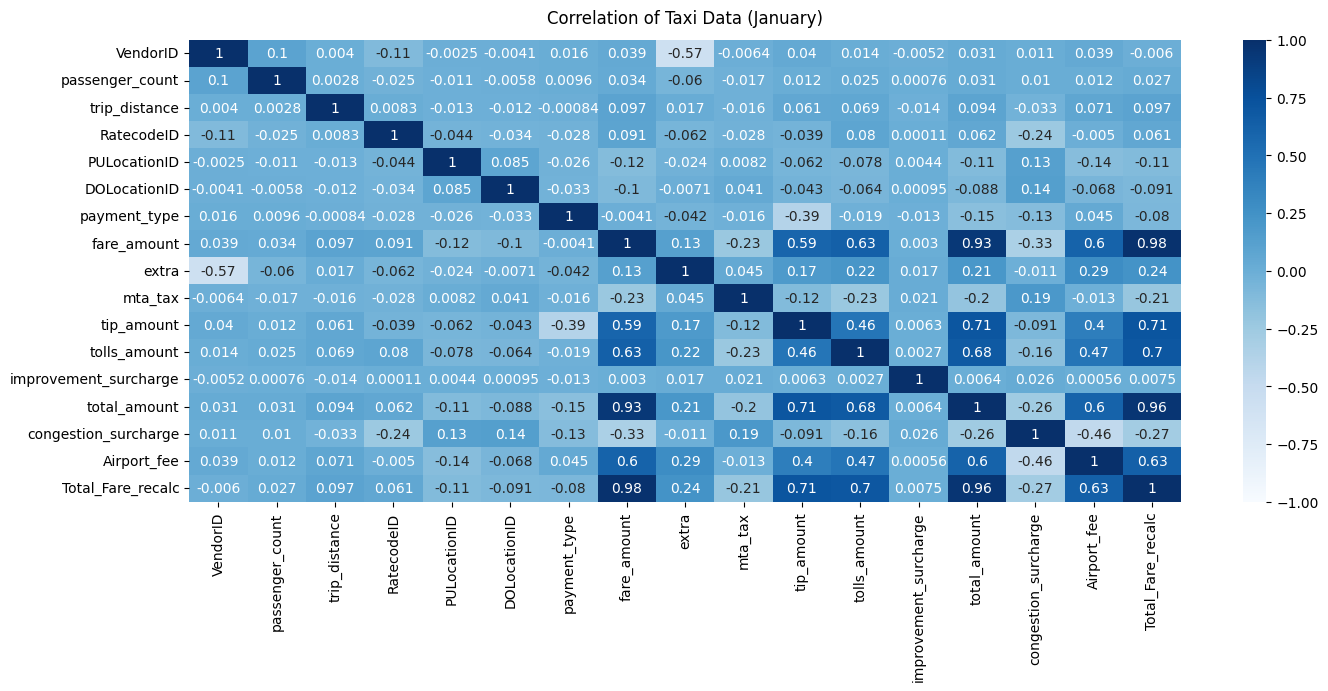

In [ ]:
plt.figure(figsize = (16,6))
htmap = sns.heatmap(corr_plot, vmin =-1, vmax=1, annot = True, cmap = 'Blues') # set the min and max to range from (-1,1)
htmap.set_title('Correlation of Taxi Data (January)', fontdict={'fontsize':12}, pad = 12)
plt.show()

#### Comments
 From the above correlation plot we observe that the `Total_Fare_recalc` is highly correlated with `fare_amount` with a correlation of $0.98$. The relationship between these two columns is naturally linearly increasing as the total amount is determined by the fare amount plus additional charges such as tolls, taxes, tips and surcharges such as the congestion surcharge. Therefore, as the amount calculated by the meter increases (the fare) so does the total amount since the total amount is an additive amount.

In [ ]:
# save output for further questions

jan_timedrop.to_parquet('/IntermediateData/Jan_cleansed15102023.parquet', engine = 'pyarrow', compression = None)

In [34]:
jan_cleaned = pd.read_parquet('IntermediateData/Jan_cleansed15102023.parquet', engine='pyarrow')

# Task 3: Featurisation

In this section, we will leverage the existing columns to create other meaningful columns in our data. The first feature we will create is whether or not a trip occurs during rush hour or not. The second feature we will create is a trip complexity field. The third feature we will create are the pick up and drop off frequencies per taxi zone.

## A) Determine whether a trip occurs in rush hour or not.

Referencing the data dictionary, customers are charged an additional amount of 50 cents under the `Extra` colum when they are travelling through rush hour traffic. However, there are multiple costs that can accumulate under this Extra column such as overnight charges and other unrecorded miscellaneous charges. For this reason, I have subsetted the data where the Extra cost charged is greater than 50 cents. Extracting the pickup hour from the pickup times, we can visualise the times of the day where there are a high volume of taxis on the road.


In [ ]:
rush_hour = jan_cleaned[jan_cleaned['extra']>= 0.5]
# want to model the rush hour by time buckets- so we get a subset of the larger dataframe
rush_hr_sub= rush_hour[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
rush_hr_sub.head()

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2023-01-01 00:32:10,2023-01-01 00:40:36
1,2023-01-01 00:55:08,2023-01-01 01:01:27
2,2023-01-01 00:25:04,2023-01-01 00:37:49
3,2023-01-01 00:03:48,2023-01-01 00:13:25
4,2023-01-01 00:10:29,2023-01-01 00:21:19


In [ ]:
# extract the hour from pickup time
rush_hr_sub['PU_Hr']= rush_hr_sub['tpep_pickup_datetime'].apply(lambda x: x.hour)


<ipython-input-7-ad40d462dcc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rush_hr_sub['PU_Hr']= rush_hr_sub['tpep_pickup_datetime'].apply(lambda x: x.hour)


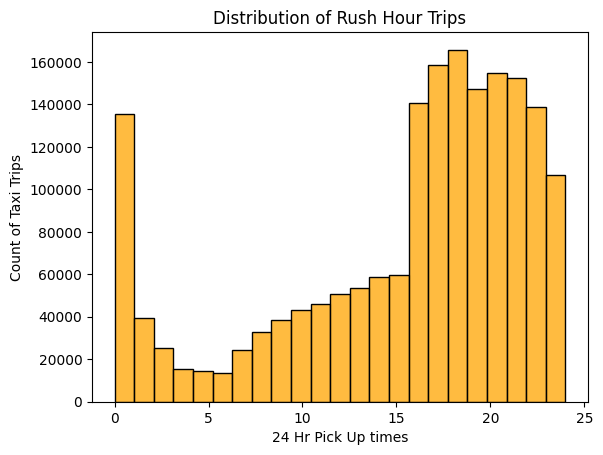

In [ ]:
sns.histplot(x="PU_Hr", data=rush_hr_sub, bins =23, binrange= [0,24], color='orange')
plt.xlabel("24 Hr Pick Up times")
plt.ylabel("Count of Taxi Trips" )
plt.title("Distribution of Rush Hour Trips")
plt.show()

### Comments


From the above histogram, rush hour in January, occurs at two distinct points in the day; 12 AM (midnight) to 1 AM, then again from 5 PM to midnight again.

Therefore, to introduce a layer of robusticity to our analysis, I classed any trips that occurred during these time intervals and was charged 50 cents as rush hour trips.  This would also include those trips that were charged miscellaneous charges as well.



In [ ]:
# apply hour field

jan_cleaned['Hour'] = jan_cleaned['tpep_pickup_datetime'].apply(lambda x: x.hour)
jan_cleaned.head()


# create rushour flag based on these two conditions
def rush_hour_flag(row):
  if (((row['Hour'] >= 0 and row['Hour']<= 2) or (row['Hour'] >= 15 and row['Hour']<= 24 )) and row['extra'] >= 0.50):
    return '1'
  else:
    return '0'




jan_cleaned['Rush_hr_flag'] = jan_cleaned.apply(rush_hour_flag, axis= 1)



In [ ]:
jan_cleaned[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'Hour', 'Rush_hr_flag', 'extra']]

,tpep_pickup_datetime,tpep_dropoff_datetime,Hour,Rush_hr_flag,extra
0,2023-01-01 00:32:10,2023-01-01 00:40:36,0,1,1.00
1,2023-01-01 00:55:08,2023-01-01 01:01:27,0,1,1.00
2,2023-01-01 00:25:04,2023-01-01 00:37:49,0,1,1.00
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0,1,7.25
4,2023-01-01 00:10:29,2023-01-01 00:21:19,0,1,1.00
...,...,...,...,...,...
2995018,2023-01-31 23:00:19,2023-02-01 00:08:33,23,0,0.00
2995019,2023-01-31 23:14:38,2023-01-31 23:25:30,23,1,1.00
2995020,2023-01-31 23:44:51,2023-01-31 23:58:45,23,1,1.00
2995021,2023-01-31 23:45:00,2023-01-31 23:55:46,23,1,3.50


In [ ]:
jan_cleaned['Rush_hr_flag'].value_counts()

0    1594426
1    1399499
Name: Rush_hr_flag, dtype: int64

Trips which were flagged as rush hour are encoded with a ‘1’ and those trips not counted as rush hour are encoded with a ‘0’. 1,399,499 trips are classified as being rush hour trips.



## B) Feature that encodes the complexity of the Trip

To determine the complexity of a trip we need to compare the straight line distance to the actual distance travelled by the taxi. There are a number of steps and caveats in this section.

Using the taxi zone shape file and the `geopandas`

1.   Using the taxi zone shape file and the `geopandas` package, generate the centroid point for each geometry object. The taxi zone shape file contains geometry information for each taxi zone, including its area, latitude and longitude for each locationID.

2.  Join the shape file with these points to the main dataset twice to get the pickup and drop off locations POINT objects.

3. Calculate the straight line distance between these points. For those taxi trips that occur within the same taxi zone, this straight line distance will result in a 0.0. In these cases I took the trip distance travelled by the taxi itself.

4. Multiply the distance computed (in metres) by the conversion factor of 0.000621 to get the distance in miles.

There a number of issues we need to make a note of:
1. The exact route taken by the taxi is unknown to us. Events like speed zones, the number of turns and street conditions ( one way traffic for example) all determine a trips complexity. We dont have this information
2. The straight line distance disregards buildings, natural landforms such as bodies of water, urban features such as parks and roadworks, thus creating an oversimplification of a metric.
3. There are a number of trips where the distance travelled is 0.0 miles as recorded by the taxi. We will not be providing a category for these trips.


Given the resources at hand, we can categorise the complexity of a trip based on the trip distance to straight line distance ratio as ‘simple’, ‘moderate’ and ‘complex’


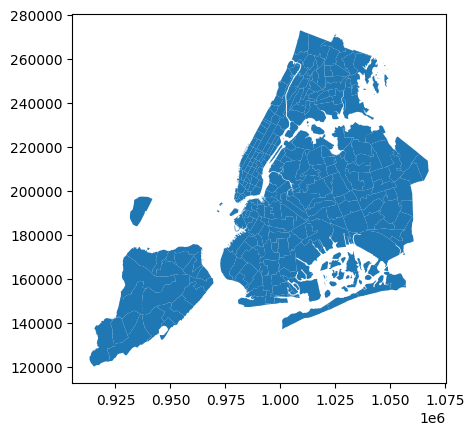

In [ ]:
# having a look at the shape file
zone_shp.plot()
plt.show()

First we calculate the centroids for each borough and taxi zone.

In [ ]:
zone_shp['centroid']= zone_shp.centroid
zone_shp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.821 191376.750)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.719 164018.754)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.617 254265.479)
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.981 202959.782)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.370 140681.351)


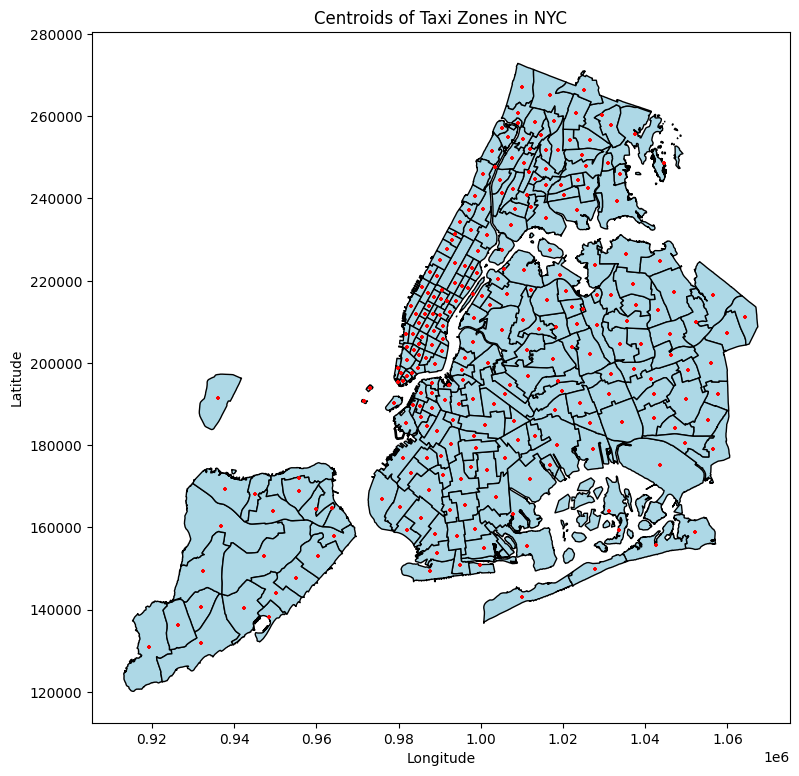

In [ ]:
# visualise the centroids against the map
centroids = zone_shp['centroid']

# Plot the centroids
ax = zone_shp.plot(figsize=(9,9), color='lightblue', edgecolor='k')
centroids.plot(ax= ax, marker = '+', color='red', markersize=5)
plt.title("Centroids of Taxi Zones in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




Then we join the shapefile information twice to the main dataset to get the coordinate points for each zone.

In [ ]:
# join pick up location id to shape file for pick up locations
zone_points = zone_shp[['LocationID','zone', 'borough', 'geometry', 'centroid' ]]

In [ ]:
jan_cleaned.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Month,Total_Fare_recalc,Hour,Rush_hr_flag
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.00,0.0,1.0,14.30,2.5,0.00,Jan,14.30,0,1
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,4.00,0.0,1.0,16.90,2.5,0.00,Jan,16.90,0,1
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,15.00,0.0,1.0,34.90,2.5,0.00,Jan,34.90,0,1
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.00,0.0,1.0,20.85,0.0,1.25,Jan,22.10,0,1
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,3.28,0.0,1.0,19.68,2.5,0.00,Jan,19.68,0,1


In [ ]:
jan_cleaned['PULocationID'].value_counts().to_frame()

In [ ]:
# first merge for Pick up location
jan_PUpoints = jan_cleaned.merge(zone_points, how = 'inner', left_on= 'PULocationID', right_on ='LocationID' )


In [ ]:
# second merge for drop off locations
jan_DOpoints =jan_PUpoints.merge(zone_points[['LocationID','centroid']], how = 'inner', left_on= 'DOLocationID', right_on ='LocationID' )

In [ ]:
jan_DOpoints['DOLocationID'].value_counts().to_frame()

In [ ]:
# Clean up the final dataset

# drop locationID_x and LocationID_y
# rename centroid_x to centroid PU, centroid_y to centroid DO

jan_centroids= jan_DOpoints.rename(columns={'centroid_x': 'PU_Centroid', 'centroid_y': 'DO_Centroid'})
# drop locationID_x and LocationID_y

jan_centroids = jan_centroids.drop(['LocationID_x','LocationID_y'] , axis =1)
jan_centroids.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Airport_fee,Month,Total_Fare_recalc,Hour,Rush_hr_flag,zone,borough,geometry,PU_Centroid,DO_Centroid
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.0,Jan,14.30,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193)
1,2,2023-01-01 00:21:43,2023-01-01 00:27:52,1.0,2.00,1.0,N,161,141,2,...,0.0,Jan,15.00,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193)
2,2,2023-01-01 00:11:44,2023-01-01 00:20:38,2.0,1.83,1.0,N,161,141,1,...,0.0,Jan,18.04,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193)
3,2,2023-01-01 00:35:52,2023-01-01 00:43:38,2.0,1.41,1.0,N,161,141,2,...,0.0,Jan,15.00,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193)
4,1,2023-01-01 00:51:12,2023-01-01 00:59:38,1.0,1.80,1.0,N,161,141,2,...,0.0,Jan,17.50,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193)


The distance calculated is in meters. For those trips that occur within the same taxi zone, the distance between the two centroids will be 0.0. For these cases we will simply take the trip distance already travelled by the taxi. To simply convert the meters to miles we can multiply by the conversion unit 0.000621371.

In [ ]:
# calculate the distance between centroids

# Function to calculate distance between 'pickup' and 'dropoff' points in a row
def calculate_distance(row):
  # handle the cases where the trip occurs within the same taxi zone
  if row['PU_Centroid']== row['DO_Centroid']:
    return row['trip_distance']
  else:
     return row['PU_Centroid'].distance(row['DO_Centroid']) * 0.000621371 # convert to miles

# Apply the function to each row to calculate distances
jan_centroids['straight_line_distance'] = jan_centroids.apply(calculate_distance, axis=1)

# Print the DataFrame with the calculated distances



In [ ]:
jan_centroids.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Month,Total_Fare_recalc,Hour,Rush_hr_flag,zone,borough,geometry,PU_Centroid,DO_Centroid,straight_line_distance
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,Jan,14.30,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458
1,2,2023-01-01 00:21:43,2023-01-01 00:27:52,1.0,2.00,1.0,N,161,141,2,...,Jan,15.00,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458
2,2,2023-01-01 00:11:44,2023-01-01 00:20:38,2.0,1.83,1.0,N,161,141,1,...,Jan,18.04,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458
3,2,2023-01-01 00:35:52,2023-01-01 00:43:38,2.0,1.41,1.0,N,161,141,2,...,Jan,15.00,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458
4,1,2023-01-01 00:51:12,2023-01-01 00:59:38,1.0,1.80,1.0,N,161,141,2,...,Jan,17.50,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458


In [ ]:
jan_centroids[jan_centroids['straight_line_distance']==0.0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Month,Total_Fare_recalc,Hour,Rush_hr_flag,zone,borough,geometry,PU_Centroid,DO_Centroid,straight_line_distance
17188,2,2023-01-01 00:09:15,2023-01-01 00:10:10,3.0,0.0,1.0,N,141,141,2,...,Jan,8.00,0,1,Lenox Hill West,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",POINT (995431.198 218699.193),POINT (995431.198 218699.193),0.0
17189,2,2023-01-01 01:54:39,2023-01-01 02:19:43,1.0,0.0,1.0,N,141,141,4,...,Jan,8.00,1,1,Lenox Hill West,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",POINT (995431.198 218699.193),POINT (995431.198 218699.193),0.0
17190,2,2023-01-01 01:54:39,2023-01-01 02:19:43,1.0,0.0,1.0,N,141,141,4,...,Jan,8.00,1,1,Lenox Hill West,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",POINT (995431.198 218699.193),POINT (995431.198 218699.193),0.0
17197,2,2023-01-01 01:05:45,2023-01-01 01:06:03,2.0,0.0,1.0,N,141,141,4,...,Jan,8.00,1,1,Lenox Hill West,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",POINT (995431.198 218699.193),POINT (995431.198 218699.193),0.0
17198,2,2023-01-01 01:05:45,2023-01-01 01:06:03,2.0,0.0,1.0,N,141,141,4,...,Jan,8.00,1,1,Lenox Hill West,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",POINT (995431.198 218699.193),POINT (995431.198 218699.193),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938290,2,2023-01-03 16:10:47,2023-01-03 16:10:59,1.0,0.0,1.0,N,30,30,2,...,Jan,7.00,16,1,Broad Channel,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",POINT (1033697.382 159266.087),POINT (1033697.382 159266.087),0.0
2938291,2,2023-01-03 16:12:27,2023-01-03 16:12:53,1.0,0.0,5.0,N,30,30,1,...,Jan,1.01,16,0,Broad Channel,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",POINT (1033697.382 159266.087),POINT (1033697.382 159266.087),0.0
2938292,2,2023-01-03 16:12:27,2023-01-03 16:12:53,1.0,0.0,5.0,N,30,30,1,...,Jan,1.01,16,0,Broad Channel,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",POINT (1033697.382 159266.087),POINT (1033697.382 159266.087),0.0
2938293,2,2023-01-09 16:19:54,2023-01-09 16:20:20,1.0,0.0,5.0,N,30,30,1,...,Jan,1.01,16,0,Broad Channel,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",POINT (1033697.382 159266.087),POINT (1033697.382 159266.087),0.0


There are 21,725 rows that have a trip distance of 0 miles. For these trips we cannot calculate the trip complexity because we cannot compare these to the straight line distances. We will have to exclude them from the following categorisation.


#### Encoding Trip complexity
To determine whether a trip is complex or not we will categorise based on the ratio of:
$$Ratio = \frac{Trip\ distance}{Straight\ Line}$$

- Simple trips: Ratio is less than 0.5 but greater than 0.
- Moderate trips: Ratio of trip distance to straightline  is between 0.5 and 1.0.
- Complex trips: Ratio of trip distance to straightline is greater than 1.0.

This has been done based on the distribution of ratios.

Where the trip distance is 0.0, the ratio has not been computed. We will need to consider dropping these rows in future analysis.

There are other factors to consider however,when classing the trip as complex or not but this is beyond the current scope for this project.
These include:
- Time of day: Trips during rush hour are more likely to be complex than trips during off-peak hours.
- Day of the week: Trips on weekends are more likely to be complex than trips on weekdays.

These factors have not been considered and implemented in this notebook.




In [ ]:
# calculate the percentage difference and store it as its own column
#percentage difference = (trip distance - straight line distance) / straight line distance * 100%

def trip_ratio(row):
  if row['straight_line_distance'] != 0.0:
    return (row['trip_distance'] / row['straight_line_distance']) # ratio of trip distances
  else:
    return 0.0

# Apply the function to each row to calculate distances
jan_centroids['trip_ratio'] = jan_centroids.apply(trip_ratio, axis=1)







In [ ]:
# check distribution of ratios to determine cut offs
jan_centroids['trip_ratio'].value_counts().to_frame()

,trip_ratio
1.000000,119222
0.000000,34133
0.326788,1600
0.294110,1531
0.261431,1451
...,...
0.416547,1
0.313728,1
0.388426,1
0.585275,1


In [ ]:
# define function to categorise trip complexity
def trip_complexity(row):
  if row['trip_ratio']>0.0 and row['trip_ratio']  <= 0.5:
    return 'Simple'
  elif row['trip_ratio'] >0.5 and row['trip_ratio'] <=1.0:
    return 'Moderate'
  elif row['trip_ratio'] > 1.0:
    return 'Complex'
  else:
    return "No category provided"


jan_centroids['Trip_complexity']= jan_centroids.apply(trip_complexity, axis=1)

In [ ]:
jan_centroids.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Hour,Rush_hr_flag,zone,borough,geometry,PU_Centroid,DO_Centroid,straight_line_distance,trip_ratio,Trip_complexity
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458,0.261635,Simple
1,2,2023-01-01 00:21:43,2023-01-01 00:27:52,1.0,2.00,1.0,N,161,141,2,...,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458,0.539453,Moderate
2,2,2023-01-01 00:11:44,2023-01-01 00:20:38,2.0,1.83,1.0,N,161,141,1,...,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458,0.493600,Simple
3,2,2023-01-01 00:35:52,2023-01-01 00:43:38,2.0,1.41,1.0,N,161,141,2,...,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458,0.380314,Simple
4,1,2023-01-01 00:51:12,2023-01-01 00:59:38,1.0,1.80,1.0,N,161,141,2,...,0,1,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),POINT (995431.198 218699.193),3.707458,0.485508,Simple


In [ ]:
jan_centroids['Trip_complexity'].value_counts().to_frame()

,Trip_complexity
Simple,2252294
Moderate,631895
No category provided,34133
Complex,20167


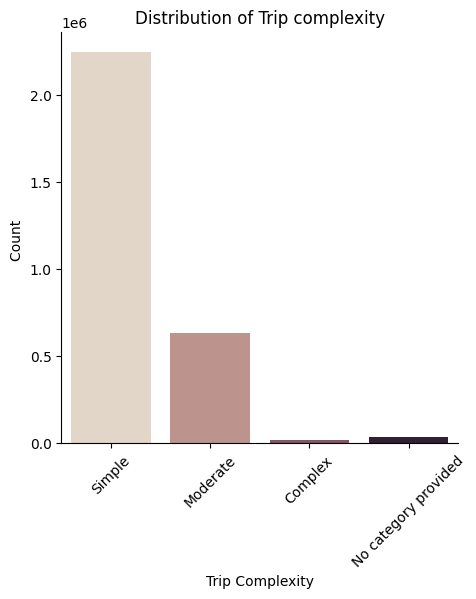

In [ ]:
sns.catplot(x="Trip_complexity", kind="count", palette="ch:.25", data=jan_centroids,order=['Simple', 'Moderate','Complex', 'No category provided'])
plt.xlabel("Trip Complexity")
plt.ylabel("Count ")
plt.title("Distribution of Trip complexity")
plt.tick_params(axis='x', rotation=45)
plt.show()


### Comments:

Majority of the trips have been classified as ‘Simple’ (2,252,294), followed by ‘Moderate’ trips (631,895) and finally only 20,167 trips have been classified as ‘Complex’. 34,133 trips have remained un-categorised as this comes down to the trip ratio being 0.0. We saw previously that approximately 21,000 trips had a trip distance of 0.0 miles. These trips also occurred as subset of those trips that occurred within the same taxi zone. The additional 12,000 trips come from a taxi trip that travelled from one zone to another therefore having a straight line distance but, the trip distance was logged as 0.0 miles. In python zero divided by an amount still yields 0.


## C) Pick Up and drop off frequencies per zone

In [ ]:
jan_centroids[['zone', 'PULocationID', 'DOLocationID']].value_counts()

zone                   PULocationID  DOLocationID
Upper East Side South  237           236             21968
Upper East Side North  236           237             18614
                                     236             14697
Upper East Side South  237           237             14382
                                     161              9268
                                                     ...  
Soundview/Castle Hill  213           135                 1
Inwood                 127           90                  1
                                     91                  1
                                     113                 1
Borough Park           26            14                  1
Length: 21299, dtype: int64

In [ ]:
PU_freq = jan_centroids.groupby('PULocationID')['PULocationID'].count()
DO_freq = jan_centroids.groupby('DOLocationID')['DOLocationID'].count()

In [ ]:
PU_freq

PULocationID
1        377
2          2
3         38
4       3107
5         55
       ...  
259       68
260      620
261    12491
262    41332
263    64145
Name: PULocationID, Length: 253, dtype: int64

In [ ]:
frequencies1 = pd.merge(zone_lookup, PU_freq.to_frame(name='PU_frequencies'), how = 'left', left_on = 'LocationID', right_on ='PULocationID')
#frequencies1.head(3)

In [ ]:
frequencies2 = pd.merge(frequencies1, DO_freq.to_frame(name='DO_frequencies'), how = 'left', left_on = 'LocationID', right_on ='DOLocationID')
#requencies2.head(3)

In [ ]:
#join frequencies to zone shape file

frequencies_shp = pd.merge( zone_shp,frequencies2[['LocationID', 'PU_frequencies', 'DO_frequencies']], how = 'inner', on = 'LocationID')

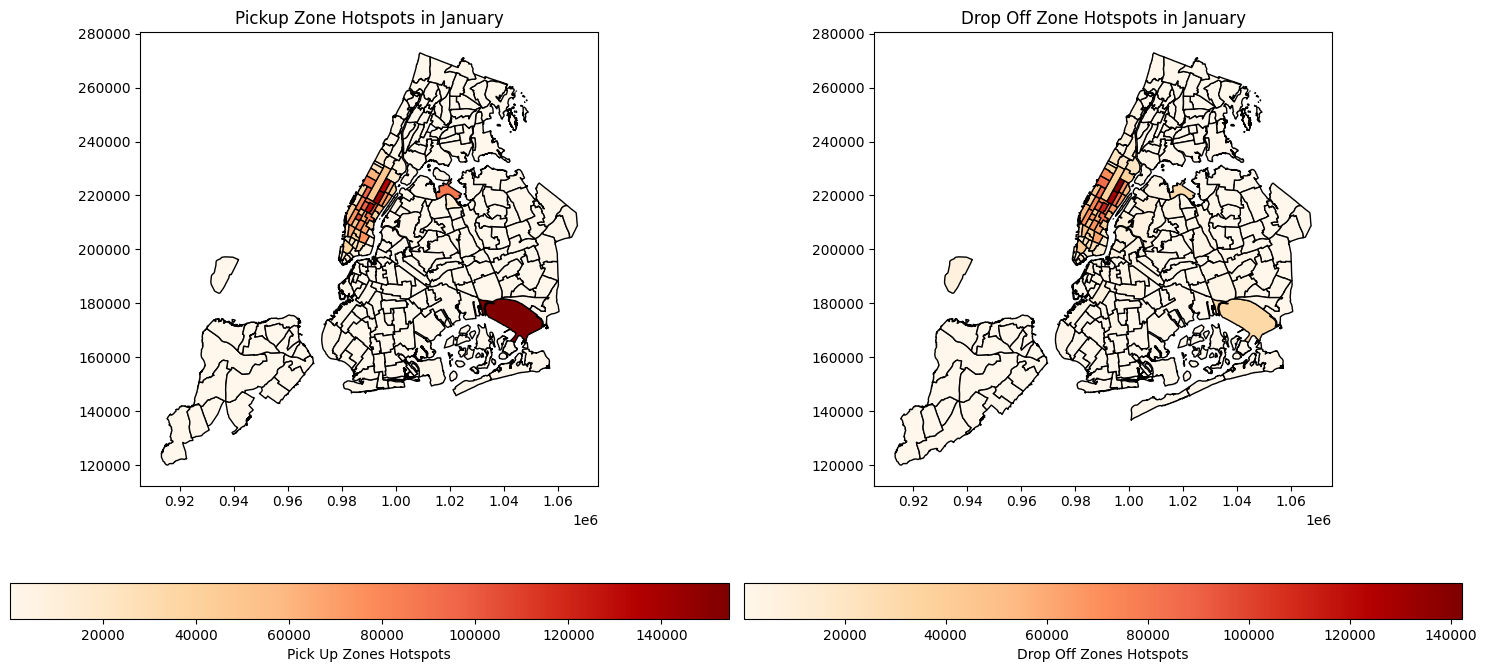

In [ ]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

#(Pick Up Zones)
frequencies_shp.plot(column='PU_frequencies',cmap='OrRd',edgecolor='k', legend=True,
                     legend_kwds={"label": "Pick Up Zones Hotspots", "orientation": "horizontal"},
                     ax=axs[0])
axs[0].set_title("Pickup Zone Hotspots in January")

# (Drop Off Zones)
frequencies_shp.plot(column='DO_frequencies',cmap='OrRd', edgecolor='k', legend=True,
                     legend_kwds={"label": "Drop Off Zones Hotspots", "orientation": "horizontal"},
                     ax=axs[1])
axs[1].set_title("Drop Off Zone Hotspots in January")


plt.tight_layout()
plt.show()

### Comments:

A highly concentrated pick up and drop off zone is the EWR borough or where JFK airport is located. Here 154,488 trips originate (people get picked up from the airport) and terminated trips are 31,235 (people get dropped off). Other hotspot locations for pickups and drop offs occur mostly in Manhattan either at Midtown Center and East zones or on the upper East side. This is further displayed in the table below.

In [ ]:
frequencies_shp[frequencies_shp['PU_frequencies']> 100000]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid,PU_frequencies,DO_frequencies
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",POINT (1043488.187 175062.678),154488.0,31235.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",POINT (990428.526 215447.527),133032.0,112588.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",POINT (991908.590 214959.582),103694.0,80411.0
185,186,0.024696,0.000037,Penn Station/Madison Sq West,186,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21...",POINT (986345.399 211974.446),107873.0,65631.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",POINT (996155.387 223613.754),134830.0,142346.0
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",POINT (993769.024 219305.828),145339.0,129093.0


# Task 4: Analysis

## A) Vendors ranked by popularity


Based on the value counts alone, vendor 2 is the most popular taxi vendor and would be ranked as first based on this.However, it would be useful to observe the most popular vendor by borough and visualise this. To do so we begin by getting a count of each vendor per borough and ranking them based on the majority.

In [ ]:
jan_centroids['rank']= jan_centroids['VendorID'].rank(method='dense')

In [ ]:
vendor_counts = jan_centroids.groupby(['borough', 'VendorID'])['VendorID'].count().reset_index(name = "Count")
vendor_counts['rank'] = vendor_counts.groupby('borough')['Count'].rank( ascending = False) #rank the most frequent first

In [ ]:
vendor_counts

,borough,VendorID,Count,rank
0,Bronx,1,3011,1.0
1,Bronx,2,874,2.0
2,Brooklyn,1,7069,2.0
3,Brooklyn,2,8294,1.0
4,EWR,1,66,2.0
5,EWR,2,311,1.0
6,Manhattan,1,714326,2.0
7,Manhattan,2,1925848,1.0
8,Queens,1,67208,2.0
9,Queens,2,211147,1.0


The most popular vendor varies from borough to borough. For example in Manhattan, vendor 2 is more popular and so is ranked first. In Staten Island however, vendor 1 is more popular. We can visualise this on the map directly.

In [ ]:
# join vendor counts to shape file based on borough
vendor_shp = pd.merge( zone_shp, vendor_counts, how = 'inner', on = 'borough')
#vendor_shp.head(3)

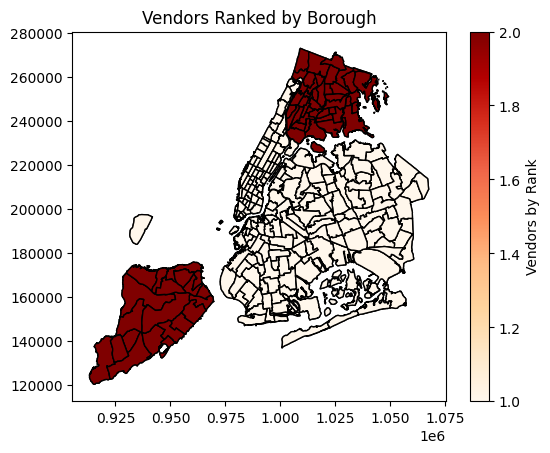

In [ ]:
# plot
vendor_shp.plot(column = 'rank',cmap='OrRd', edgecolor='k', legend=True,
                     legend_kwds={"label": "Vendors by Rank"})
plt.title("Vendors Ranked by Borough")
plt.show()

## B) Peak Travel Hours

Rush hour, as we saw in the above analysis happened at roughly two distinct parts of the day with a lull inbetween and mostly refers to the large volume of drivers or vehicles on the road.

Rush hour might exist within peak travel times which is defined as the volume of vehicles on the road as well as the duration spent on the roads.





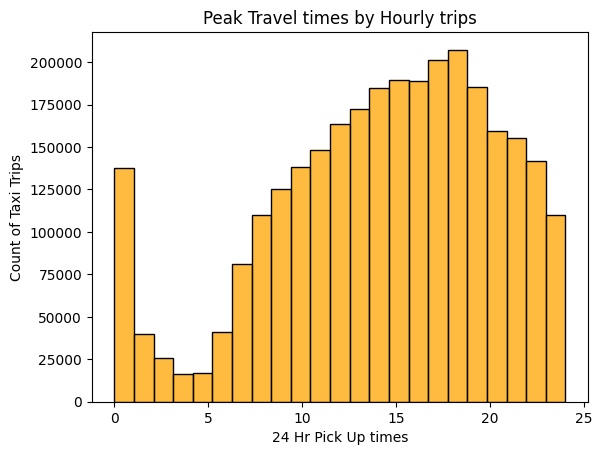

In [ ]:
sns.histplot(x="Hour", data=jan_centroids, bins =23, binrange= [0,24], color='orange')
plt.xlabel("24 Hr Pick Up times")
plt.ylabel("Count of Taxi Trips" )
plt.title("Peak Travel times by Hourly trips")
plt.show()

### Comments:

From the above plot we can see that the peak travel times spans from 10 AM in the morning to 1 AM the following day.
With a dramatic lull in the taxi trips between 1 AM and 8 AM. There is an overlap with rush hour travel times from 5-6 PM where taxi-trips are at an all high for January.

## C) Average Distance travelled on weekdays vs Weekends

To find the average distance travelled on weekdays and weekends, and then the average number of passengers over weekends and weekdays in the next section we can subset the data into a weekday set and a weekend set. I have then extracted the day from the pickup time and stored it as a string. This allows us to calculate the average number of passengers and distance.

In [ ]:
import calendar
from datetime import date

In [ ]:
# only keep columns trip distance, pickup time and passenger count

jan_dist = jan_centroids[['tpep_pickup_datetime', 'trip_distance', 'passenger_count']]
# extract the day from the pickup time

jan_dist['day']= jan_dist['tpep_pickup_datetime'].dt.strftime('%A')

jan_dist.head()

<ipython-input-71-f23c0c716c60>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_dist['day']= jan_dist['tpep_pickup_datetime'].dt.strftime('%A')


,tpep_pickup_datetime,trip_distance,passenger_count,day
0,2023-01-01 00:32:10,0.97,1.0,Sunday
1,2023-01-01 00:21:43,2.00,1.0,Sunday
2,2023-01-01 00:11:44,1.83,2.0,Sunday
3,2023-01-01 00:35:52,1.41,2.0,Sunday
4,2023-01-01 00:51:12,1.80,1.0,Sunday


In [ ]:
jan_dist.shape

(2938489, 4)

In [ ]:
weekdays_ls = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends_ls = ['Saturday', 'Sunday']

In [ ]:
weekdays = jan_dist[jan_dist['day'].isin(weekdays_ls) & jan_dist['trip_distance']>0.0]
weekdays.shape

(2073278, 4)

In [ ]:
weekends= jan_dist[jan_dist['day'].isin(weekends_ls)& jan_dist['trip_distance']>0.0]
weekends.shape

(831078, 4)

There are 2,073,278 trips that happen across weekdays throughout the entirety of January.

There are 831,078 trips that happen across all weekends of January.

We are only considering trips where the distance is greater than 0.0 miles. As expected majority of traffic flow occurs during the week.

In [ ]:
# overall average  distance of  weekday trips
average_overall = weekdays['trip_distance'].mean()
print("The January overall weekday average of trip distances is {0:.2f} miles".format(average_overall))

The January overall weekday average of trip distances is 3.31 miles


In [ ]:
# calculate the average distance of trips per week day across january

average_daily_dist = weekdays.groupby('day')['trip_distance'].mean()
a = average_daily_dist.reset_index()
a.index=[0]*len(a) # change the index to a single valye
avg_wkday = a.pivot(columns = 'day', values = 'trip_distance', index = None)[weekdays_ls] # pivot and reorder the columns

avg_wkday_f= avg_wkday.applymap(lambda x: "{0:.2f}".format(x))
avg_wkday_f

day,Monday,Tuesday,Wednesday,Thursday,Friday
0,3.73,3.29,3.14,3.18,3.25


### Comments
Throughout January, the per weekday the average trip distance is displayed above.
Trip distances average out to approximately 3 miles per day.
It appears that Mondays see longer trips on average where as Wednesday sees shorter trips on average. These differences are minute though.


In [ ]:
average_overall_wknd = weekends['trip_distance'].mean()
print("The January overall weekday average of trip distances is {0:.2f} miles".format(average_overall_wknd))

The January overall weekday average of trip distances is 3.51 miles


In [ ]:
# average distance of trips per day over the weekend
average_wkend_dist = weekends.groupby('day')['trip_distance'].mean()
a = average_wkend_dist.reset_index()
a.index=[0]*len(a) # change the index to a single valye
avg_wkend = a.pivot(columns = 'day', values = 'trip_distance', index = None)[weekends_ls] # pivot and reorder the columns

avg_wkend_f= avg_wkend.applymap(lambda x: "{0:.2f}".format(x))
avg_wkend_f

day,Saturday,Sunday
0,3.10,3.93



## Comments:
Further broken down by each weekend day the average distance travelled on Saturday (3.10 )is less than the distance travelled on Sundays (3.93).

Overall, the trips taken over the weekend tend to be longer than weekday trips on average.

## D) Average Number of Passengers on weekdays and weekends

Leveraging the `jan_dist` dataframe we created above, we will replicate the analysis for the average number of passengers that travel across weekdays and weekends

In [ ]:
weekdays_p = jan_dist[jan_dist['day'].isin(weekdays_ls) & jan_dist['passenger_count']>0.0]
weekdays_p.shape

(2062401, 4)

In [ ]:
weekends= jan_dist[jan_dist['day'].isin(weekends_ls)& jan_dist['passenger_count']>0.0]
weekends.shape

(825924, 4)

There are 2,062,401 trips that have a passenger count greater than 0 and occur on weekdays.

There are 825, 924 trips that have a passenger count greater than 0 and occur on weekends.

In [ ]:
# overall average  number of passengers of  weekday trips
average_overall = weekdays['passenger_count'].mean()
print("The January overall weekday passenger count is {0:.1f} passenger(s)".format(average_overall))

The January overall weekday passenger count is 1.3 passenger(s)


In [ ]:
average_daily_pass = weekdays.groupby('day')['passenger_count'].mean()
a = average_daily_pass.reset_index()
a.index=[0]*len(a) # change the index to a single valye
avg_wkday = a.pivot(columns = 'day', values = 'passenger_count', index = None)[weekdays_ls] # pivot and reorder the columns

avg_wkday_f= avg_wkday.applymap(lambda x: "{0:.1f}".format(x))
avg_wkday_f

day,Monday,Tuesday,Wednesday,Thursday,Friday
0,1.4,1.3,1.3,1.3,1.4


### Comments
The overall average passenger count across the weekdays is 1-2 people. Since we cannot have partial passengers (1.4 is not a real values in this context) our average will be 1-2 people.
These largely single passenger trips definitely contribute to the rush hour and peak travel volumes on the roads.

In [ ]:
average_overall_wknd = weekends['passenger_count'].mean()
print("The January overall weekday passenger count is {0:.1f} passenger(s)".format(average_overall_wknd))

The January overall weekday passenger count is 1.5 passenger(s)


In [ ]:
# average distance of trips per day over the weekend
average_wkend_pass = weekends.groupby('day')['passenger_count'].mean()
a = average_wkend_pass.reset_index()
a.index=[0]*len(a) # change the index to a single valye
avg_wkend = a.pivot(columns = 'day', values = 'passenger_count', index = None)[weekends_ls] # pivot and reorder the columns

avg_wkend_f= avg_wkend.applymap(lambda x: "{0:.1f}".format(x))
avg_wkend_f

day,Saturday,Sunday
0,1.5,1.5


### Comments
The overall average passenger count across the weekdays is 1-2 people. Since we cannot have partial passengers (1.5 is not a real values in this context) our average will be 1-2 people.
We expect that weekend trips on average will have more passengers as the weekends tend to be times where friends and family commute together from location to location.



## E&F) Correlation

In this section we will construct a correlation plot and answer the following questions

1) What is the correlation between the fare amount and the tip paid

2) What is the correlation between the fare amount and the number of passengers?

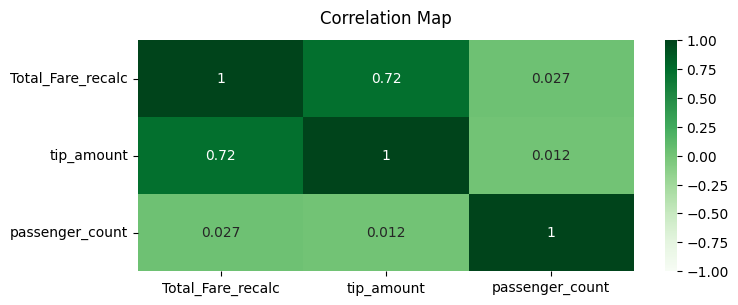

In [ ]:
# construct the correlation plot

jan_sub = jan_centroids[['Total_Fare_recalc','tip_amount','passenger_count']]
corr_plot =jan_sub.corr()
plt.figure(figsize = (8,3))
htmap = sns.heatmap(corr_plot, vmin =-1, vmax=1, annot = True, cmap = 'Greens') # set the min and max to range from (-1,1)
htmap.set_title('Correlation Map', fontdict={'fontsize':12}, pad = 12)
plt.show()

The correlation between the fare amount and tip amount is 0.72. It is a strong linear relationshio between the two because the fare amount will increase if tips are paid by the passenger. It is important to note that cash tips are not included in this relationship therefore the correlation between these two columns has the potential to be higher.


The correlation between the number of passengers and the total fare paid is linear but weak (0.027). According to [NYC's Government site ](https://https://www.nyc.gov/site/tlc/passengers/taxi-fare.page), the fare amount does not increase with increasing passenger count in that there are no additional charges for additional passengers. This would explain the weak correlation between the two columns.

# Task 5: Conclusion

## A) Summary of key findings

Taxi trip data is a high volume dataset that captures only a fraction of the road traffic that New York City faces on a day to day, month to month basis.
In terms of pick up and drop off zones, like any other city, there are central hotspot locations where passengers are commuting to and from. The two marked locations are Manhattan and the JFK airport. The second major finding is that vendor popularity is pretty polarised within each borough. The third major finding is that rush hour and peak travel times extend well into the night in New York. However it makes sense since New York is dubbed as the 'City that never sleeps', the financial markets are always active even at night in the central hub and New York is also a travel hotspot throughout the year meaning that there is lots of overnight activity occurring and therefore the demand for taxis will be high.



## B) Challenges Faced

Perhaps the most challenging aspect of this project was gaining an understanding of the data and preparing it for analysis. Issues such as handling missing values, negative dollar amounts or other noisy and erroneous data consumed the most time in getting the data actually ready for analysis. Additionally, we had to subset the combined 3 months repeatedly to see granular trends otherwise the similarity between trips doesn't reveal any useful information for us.

While there is a large amount of data available, answering questions such as determining trip complexity was made difficult because we didn't have enough information to deem a trip's complexity apart from its distance and rush hour attributes but routes taken would hav pointed to a more complex trip. So methods used to answer such questions become incredibly reductive.
Another personal challenge was working with spatial data and visualising trends. Being not all that familiar with spatial data it was a slight learning curve in understanding how `geopandas` operated and overlaying different plot features over one another.


## C) Next steps for future analysis.

Taxi trip data is a high volume dataset that captures only a fraction of the road traffic that New York City faces on a day to day, month to month basis. There is immense potential to analyse this data and present traffic modelling analyses to infer demand and supply. This could be especially useful to infer and predict taxi cab demand for those zones with high pickup and drop off frequencies. NYC could also use this data as a form of object modelling to handle and better manage traffic congestion within the city to ease overcrowding and improve the overall experience for drivers and customers.

For smaller scale projects for myself, I could use this data and other supplementary data to predict aspects of a trip such as whether or not I'll end up in rush hour if I travel at X time for example.